In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# load dataset
file_path = '/content/EEG.machinelearing_data_BRMH.csv'
data = pd.read_csv(file_path)

# metadata
metadata_columns = ['sex', 'age', 'education', 'IQ']

# condition columns
condition_columns = ['main.disorder', 'specific.disorder']

# time-series columns
time_series_columns = [col for col in data.columns if col.startswith('AB.') or col.startswith('COH.')]

# preprocess conditions
ohe = OneHotEncoder(sparse_output=False)
condition_matrix = ohe.fit_transform(data[condition_columns])

# normalize time-series data
scaler = MinMaxScaler()
time_series_data = scaler.fit_transform(data[time_series_columns])

# reshape time-series data
seq_length = len(time_series_columns)
time_series_data = time_series_data.reshape(-1, seq_length, 1)

# split data
X_train, X_test, y_train, y_test = train_test_split(time_series_data, condition_matrix, test_size=0.2, random_state=42)

# convert to PyTorch Tensors

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [2]:
# normalize input data for Time-Series
def normalize_time_series(data):
    """
    Normalize 3D time-series data (samples, timesteps, features).
    Flattens, scales, and reshapes the data.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    num_samples, timesteps, features = data.shape

    # flatten to 2D: (samples * timesteps, features)
    data_2d = data.reshape(-1, features)

    # scale
    data_scaled = scaler.fit_transform(data_2d)

    # reshape back to 3D
    data_3d = data_scaled.reshape(num_samples, timesteps, features)
    return data_3d, scaler

# normalize train and test data
X_train_normalized, scaler = normalize_time_series(X_train)
X_test_normalized, _ = normalize_time_series(X_test)

# convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [3]:
# define the updated CVAE Model
class TimeSeriesCVAE(nn.Module):
    def __init__(self, seq_length, condition_dim, latent_dim):
        super(TimeSeriesCVAE, self).__init__()
        self.hidden_size = 128  # increased hidden size

        # encoder
        self.encoder_lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size,
                                    num_layers=2, batch_first=True, dropout=0.2)
        self.fc_mu = nn.Linear(self.hidden_size + condition_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.hidden_size + condition_dim, latent_dim)

        # decoder
        self.decoder_lstm = nn.LSTM(input_size=latent_dim + condition_dim, hidden_size=self.hidden_size,
                                    num_layers=2, batch_first=True, dropout=0.2)
        self.decoder_output = nn.Linear(self.hidden_size, 1)

    def encode(self, x, c):
        _, (h, _) = self.encoder_lstm(x)
        h = h[-1]  # take the last hidden state
        h = torch.cat([h, c], dim=1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, seq_length):
        z = z.unsqueeze(1).repeat(1, seq_length, 1)
        c = c.unsqueeze(1).repeat(1, seq_length, 1)
        zc = torch.cat([z, c], dim=2)
        output, _ = self.decoder_lstm(zc)
        return self.decoder_output(output)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c, x.size(1)), mu, logvar

# loss function
def cvae_loss(recon_x, x, mu, logvar, beta=0.1):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + beta * kl_divergence

# train the updated CVAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seq_length = X_train_tensor.shape[1]
condition_dim = y_train_tensor.shape[1]
latent_dim = 16

cvae = TimeSeriesCVAE(seq_length, condition_dim, latent_dim).to(device)
optimizer = optim.Adam(cvae.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

cvae.train()
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = 0
    recon_loss_total = 0
    kl_div_total = 0
    mae_total = 0
    r2_total = 0
    total_samples = 0

    for batch in train_loader:
        x, c = batch[0].to(device), batch[1].to(device)  # add channel dimension
        batch_size = x.size(0)
        total_samples += batch_size

        optimizer.zero_grad()
        recon_x, mu, logvar = cvae(x, c)

        # Loss calculation
        recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
        loss = recon_loss + 0.1 * kl_divergence

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Collect losses and metrics
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_div_total += kl_divergence.item()

        # Additional metrics: MAE and R²
        mae = nn.functional.l1_loss(recon_x, x, reduction='mean').item()
        ss_total = torch.sum((x - x.mean(dim=0, keepdim=True)) ** 2).item()
        ss_residual = torch.sum((x - recon_x) ** 2).item()
        r2 = 1 - ss_residual / ss_total if ss_total > 0 else 0

        mae_total += mae * batch_size  # weighted average
        r2_total += r2 * batch_size  # weighted average

    # Average metrics over all samples
    avg_loss = train_loss / len(train_loader)
    avg_recon_loss = recon_loss_total / len(train_loader)
    avg_kl_div = kl_div_total / len(train_loader)
    avg_mae = mae_total / total_samples
    avg_r2 = r2_total / total_samples

    scheduler.step(train_loss)

    # Print metrics for the epoch
    print(f"Epoch {epoch + 1}:")
    print(f"  Total Loss: {avg_loss:.4f}")
    print(f"  Reconstruction Loss: {avg_recon_loss:.4f}")
    print(f"  KL Divergence: {avg_kl_div:.4f}")
    print(f"  MAE: {avg_mae:.4f}")
    print(f"  R²: {avg_r2:.4f}")

print("Training complete.")


Epoch 1:
  Total Loss: 0.1057
  Reconstruction Loss: 0.1005
  KL Divergence: 0.0519
  MAE: 0.2565
  R²: -2.4665
Epoch 2:
  Total Loss: 0.0714
  Reconstruction Loss: 0.0687
  KL Divergence: 0.0272
  MAE: 0.2204
  R²: -1.3025
Epoch 3:
  Total Loss: 0.0693
  Reconstruction Loss: 0.0679
  KL Divergence: 0.0148
  MAE: 0.2227
  R²: -1.2783
Epoch 4:
  Total Loss: 0.0678
  Reconstruction Loss: 0.0670
  KL Divergence: 0.0078
  MAE: 0.2200
  R²: -1.2421
Epoch 5:
  Total Loss: 0.0673
  Reconstruction Loss: 0.0669
  KL Divergence: 0.0040
  MAE: 0.2209
  R²: -1.2489
Epoch 6:
  Total Loss: 0.0670
  Reconstruction Loss: 0.0668
  KL Divergence: 0.0021
  MAE: 0.2201
  R²: -1.2467
Epoch 7:
  Total Loss: 0.0668
  Reconstruction Loss: 0.0667
  KL Divergence: 0.0011
  MAE: 0.2205
  R²: -1.2304
Epoch 8:
  Total Loss: 0.0668
  Reconstruction Loss: 0.0668
  KL Divergence: 0.0006
  MAE: 0.2206
  R²: -1.2519
Epoch 9:
  Total Loss: 0.0671
  Reconstruction Loss: 0.0670
  KL Divergence: 0.0003
  MAE: 0.2208
  R²: 

In [4]:
def compute_dci(latent_vectors, labels):

    num_latent_dims = latent_vectors.shape[1]
    num_factors = labels.shape[1]

    importance_matrix = np.zeros((num_latent_dims, num_factors))
    informativeness_scores = []

    for i in range(num_factors):
        # train a logistic regression model for each factor
        factor_labels = labels[:, i]
        model = LogisticRegression(max_iter=1000)
        model.fit(latent_vectors, factor_labels)

        # record importance scores (coefficients)
        importance_matrix[:, i] = np.abs(model.coef_).mean(axis=0)

        # compute informativeness (accuracy)
        predictions = model.predict(latent_vectors)
        informativeness_scores.append(accuracy_score(factor_labels, predictions))

    # normalize importance matrix
    importance_matrix /= importance_matrix.sum(axis=0, keepdims=True)

    # disentanglement
    disentanglement_scores = 1.0 - importance_matrix.var(axis=1)
    disentanglement = disentanglement_scores.mean()

    # completeness
    completeness_scores = 1.0 - importance_matrix.var(axis=0)
    completeness = completeness_scores.mean()

    # informativeness
    informativeness = np.mean(informativeness_scores)

    return {
        "disentanglement": disentanglement,
        "completeness": completeness,
        "informativeness": informativeness
    }

cvae.eval()
latent_vectors = []
labels = []

# extract latent representations and labels
with torch.no_grad():
    for batch in train_loader:
        x, c = batch[0].to(device), batch[1].to(device)
        mu, _ = cvae.encode(x, c)
        latent_vectors.append(mu.cpu().numpy())
        labels.append(c.cpu().numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

# compute DCI metrics
dci_metrics = compute_dci(latent_vectors, labels)
print("DCI Metrics:", dci_metrics)


DCI Metrics: {'disentanglement': 0.99751204322918, 'completeness': 0.9972158260350066, 'informativeness': 0.8947368421052632}


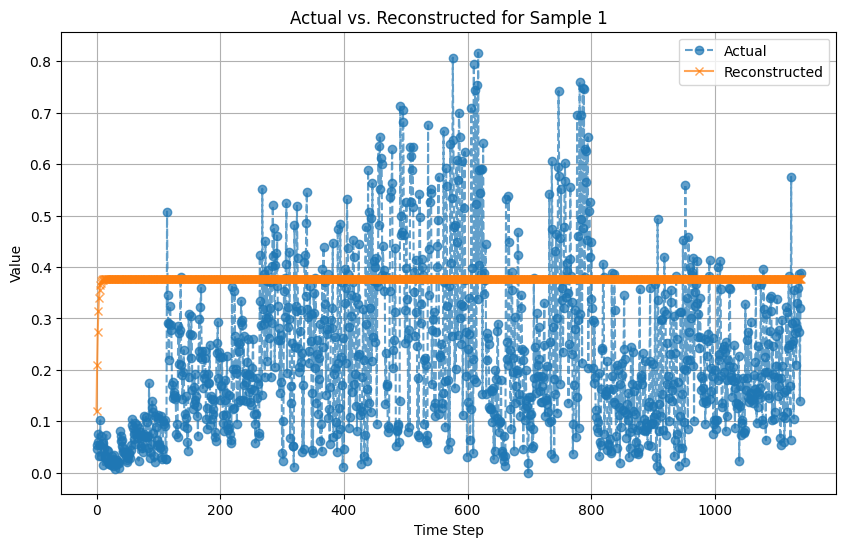

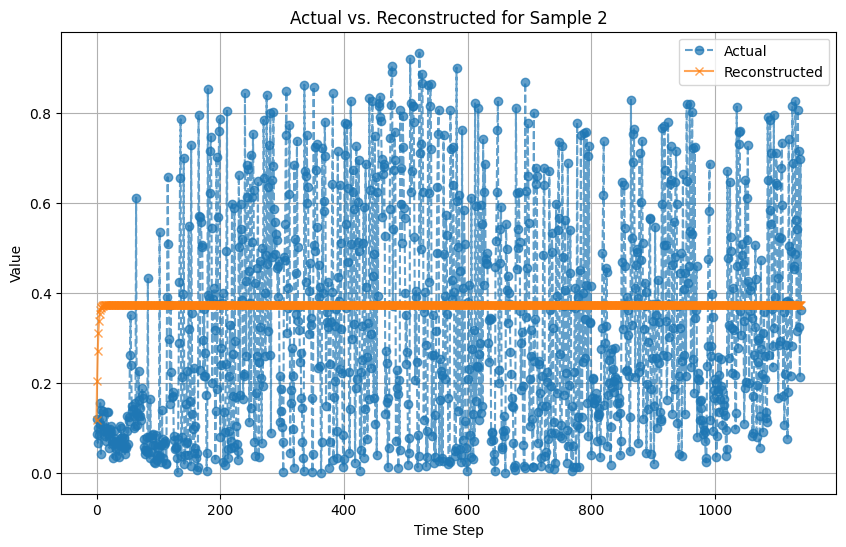

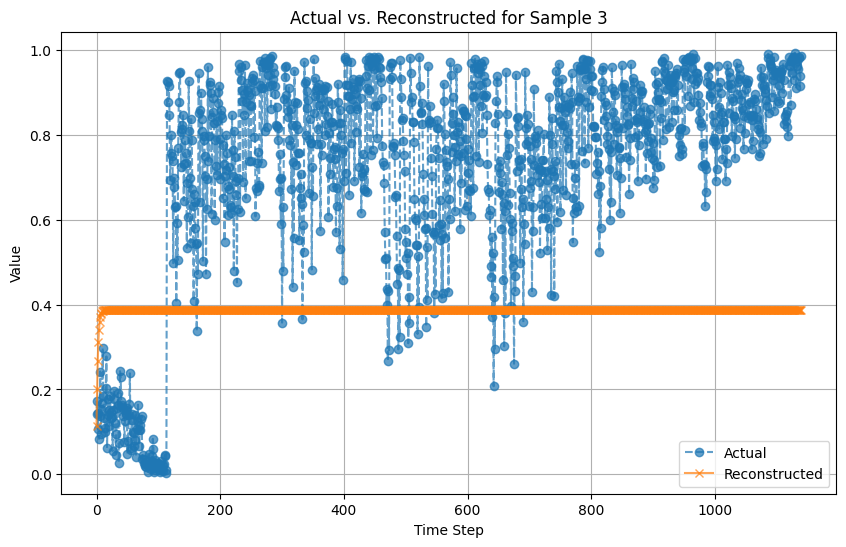

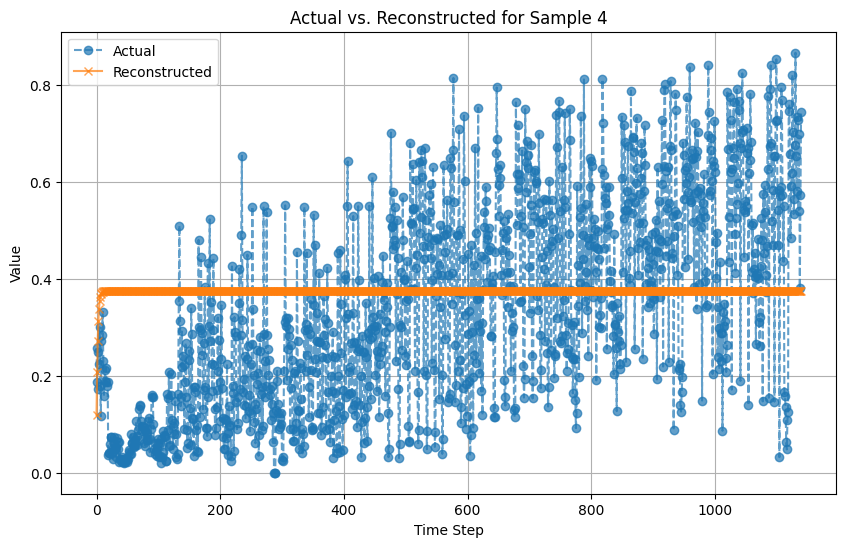

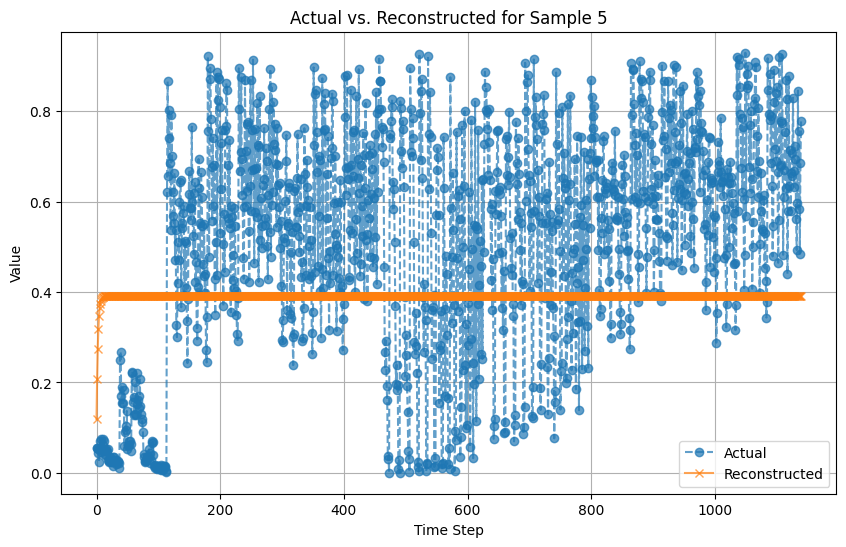

In [5]:
def visualize_actual_vs_reconstructed(model, data_loader, condition_name, num_samples=5):

    model.eval()
    actual_data = []
    reconstructed_data = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            x, c = batch[0].to(device), batch[1].to(device)

            # find samples for the specific condition
            condition_mask = c[:, condition_name] == 1  # adjust for specific one-hot encoding index
            if condition_mask.sum() == 0:
                continue

            filtered_x = x[condition_mask]
            filtered_c = c[condition_mask]

            # reconstruct
            recon_x, _, _ = model(filtered_x, filtered_c)

            actual_data.append(filtered_x.cpu().numpy())
            reconstructed_data.append(recon_x.cpu().numpy())
            labels.append(filtered_c.cpu().numpy())

            # break if enough samples are collected
            if len(actual_data) >= num_samples:
                break

    # convert lists to arrays
    actual_data = np.concatenate(actual_data, axis=0)
    reconstructed_data = np.concatenate(reconstructed_data, axis=0)

    # plot actual vs reconstructed
    for i in range(num_samples):
        plt.figure(figsize=(10, 6))
        plt.plot(actual_data[i].squeeze(), label="Actual", linestyle="--", marker="o", alpha=0.7)
        plt.plot(reconstructed_data[i].squeeze(), label="Reconstructed", linestyle="-", marker="x", alpha=0.7)
        plt.title(f"Actual vs. Reconstructed for Sample {i+1}")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
        plt.grid()
        plt.show()


condition_index = 0
visualize_actual_vs_reconstructed(cvae, test_loader, condition_name=condition_index, num_samples=5)


In [6]:
def extract_latent_space(model, data_loader):
    model.eval()
    latent_representations = []
    conditions = []

    with torch.no_grad():
        for batch in data_loader:
            x, c = batch[0].to(device), batch[1].to(device)
            mu, logvar = model.encode(x, c)
            z = model.reparameterize(mu, logvar)
            latent_representations.append(z.cpu().numpy())
            conditions.append(c.cpu().numpy())

    latent_representations = np.concatenate(latent_representations, axis=0)
    conditions = np.concatenate(conditions, axis=0)
    return latent_representations, conditions


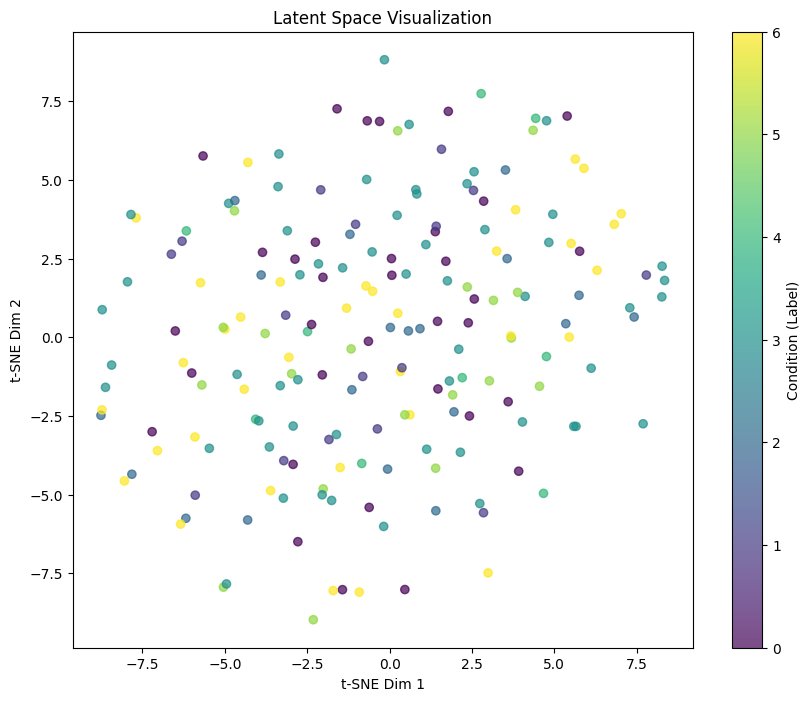

In [7]:
# extract latent space
latent_representations, conditions = extract_latent_space(cvae, test_loader)

# reduce dimensionality (to 2D for visualization)
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_representations)

# plot latent space with conditions
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=np.argmax(conditions, axis=1), cmap='viridis', alpha=0.7)
plt.colorbar(label="Condition (Label)")
plt.title("Latent Space Visualization")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()


In [8]:
import plotly.express as px

fig = px.scatter(x=latent_2d[:, 0], y=latent_2d[:, 1],
                 color=np.argmax(conditions, axis=1),
                 title="Latent Space Visualization",
                 labels={"x": "t-SNE Dim 1", "y": "t-SNE Dim 2", "color": "Condition"})
fig.show()
